In [10]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.close('all')

from evaluate import *

In [2]:
examplesDf = getExamplesDf('../../datasets/test.csv')
examplesSize = examplesDf.shape[0]
print('examplesDf ', examplesDf.shape)
mfogDF = getMatchesDf('../../out/matches.csv')
print('mfogDF ', mfogDF.shape)
# minasDF = getMatchesDf('../../out/minas-og/2020-07-20T18-36-59.803/matches.csv')
minasDF = getMatchesDf('../../out/minas-og/2020-07-20T12-18-21.758/matches.csv')
print('minasDF ', minasDF.shape)
ogdf = getOriginalMatchesDf('../../out/minas-og/2020-07-20T12-21-54.755/results')
print('ogdf ', ogdf.shape)

# newMatDF = getMatchesDf('../../out/minas-og/2020-07-22T21-46-01.167/matches.csv')
# diffMinasMfog(examplesDf, minasDF, newMatDF)

examplesDf  (653457, 25)
mfogDF  (659249, 9)
minasDF  (665107, 9)
ogdf  (653457, 2)


In [3]:
cf = confusionMatrix(examplesDf, mfogDF)[0]
print('mfog hits', cf['hits'].sum())
minasCF = confusionMatrix(examplesDf, minasDF)[0]
print('minas hits', minasCF['hits'].sum())

# printEval(examplesDf, mfogDF)
# printEval(examplesDf, ogdf)
# printEval(examplesDf, ogndDf)

diffMinasMfog(examplesDf, minasDF, mfogDF)

mfog hits 214243
minas hits 207669
### Minas

examples  (653457, 25)
matches   (665107, 9)
Confusion Matrix
Classes (act)       A       N assigned    hits
Labels (pred)                                 
-                3774    8206        -       0
1                 123       0        A     123
10               3520    5130        N    5130
11                 71     289        N     289
12                 26       0        A      26
2                 152      82        A     152
3                 368      44        A     368
4                   8       0        A       8
5                  82       1        A      82
6                 165       0        A     165
7                   8     396        N     396
8                1054     183        A    1054
9                 161     154        A     161
N              441395  199715        N  199715
Classes           ['A' 'N']
Labels            ['-', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', 'N'] 14
Initial labels   

,#pointId_x,clusterLabel_x,clusterCategory_x,clusterId_x,clusterRadius_x,label_x,distance_x,secondDistance_x,id,#pointId_y,clusterLabel_y,clusterCategory_y,clusterId_y,clusterRadius_y,label_y,distance_y,secondDistance_y
88,88,N,normal,0,1.026340,-,1.105216,1.250370,88,88,N,n,19,1.453797,N,1.105437,1.738522
286,286,N,normal,0,1.026340,-,1.097748,1.225880,286,286,N,n,19,1.453797,N,1.097847,1.721652
410,410,N,normal,0,1.026340,-,1.083439,1.212726,410,410,N,n,19,1.453797,N,1.083677,1.650951
539,539,N,normal,0,1.026340,-,1.085700,1.235717,539,539,N,n,19,1.453797,N,1.086120,1.652822
723,723,N,normal,0,1.026340,-,1.086764,1.216089,723,723,N,n,19,1.453797,N,1.086905,1.695172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671133,653288,10,extNov,0,0.953439,-,1.005741,1.177649,653288,653288,f,e,224,0.471080,f,0.120054,1.000100
671177,653332,10,extNov,0,0.953439,-,1.005741,1.177649,653332,653332,f,e,224,0.471080,f,0.120054,1.000100
671190,653345,3,extNov,0,0.750654,3,0.155509,0.162869,653345,653345,N,e,110,1.177876,N,0.694689,1.089072
671208,653363,10,extNov,0,1.225131,10,0.448390,0.975999,653363,653363,N,n,2,1.509374,N,0.444244,2.299103


modelDF (100, 29)
mfogModelDF (100, 29)
model diff min 8.673617379884035e-19
model diff meanDistance 0.5456153251522232


,matches,meanDistance,radius,c0,c1,c2,c3,c4,c5,c6,...,c13,c14,c15,c16,c17,c18,c19,c20,c21,matches_p
0,226.0,0.003567,0.125068,3.174582e-04,0.000022,0.000763,0.002462,0.003623,NaN,0.002512,...,NaN,0.003623,NaN,NaN,NaN,NaN,0.003623,NaN,NaN,0.003139
1,42.0,0.013876,0.000590,3.360920e-04,0.000154,0.002828,0.007343,0.003541,2.723533e-05,0.005149,...,NaN,0.002833,NaN,NaN,NaN,NaN,0.002833,NaN,NaN,0.000583
2,1.0,0.001023,0.000562,9.159999e-04,0.000256,0.000489,0.000003,NaN,1.414742e-05,NaN,...,NaN,NaN,NaN,0.001681,NaN,NaN,NaN,0.001681,NaN,0.000014
3,8.0,0.000255,0.000078,1.305654e-04,0.000024,0.000613,0.000073,0.000293,1.795379e-05,NaN,...,0.001175,NaN,NaN,NaN,NaN,NaN,NaN,0.001175,NaN,0.000111
4,18.0,0.000398,0.000966,8.986134e-08,0.000025,0.000003,0.000361,0.001109,NaN,0.000108,...,NaN,0.001091,NaN,NaN,NaN,NaN,0.001091,NaN,NaN,0.000250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,273.0,NaN,0.032889,8.749700e-05,0.022020,0.028887,0.077752,1.000000,NaN,NaN,...,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.003792
96,1.0,0.007160,0.002752,1.213937e-03,0.000126,NaN,0.002026,0.021277,2.127660e-02,0.019389,...,NaN,NaN,NaN,NaN,0.015726,NaN,0.021277,NaN,NaN,0.000014
97,1.0,0.000086,0.000190,5.528321e-07,0.000048,0.000060,0.000093,0.001370,8.245153e-07,0.000176,...,NaN,0.001370,NaN,NaN,NaN,NaN,0.001370,NaN,NaN,0.000014
98,3.0,0.002238,0.000910,7.785078e-06,0.000042,0.000196,0.000133,0.003268,2.823810e-05,0.001188,...,NaN,0.003268,NaN,NaN,NaN,NaN,0.003268,NaN,NaN,0.000042


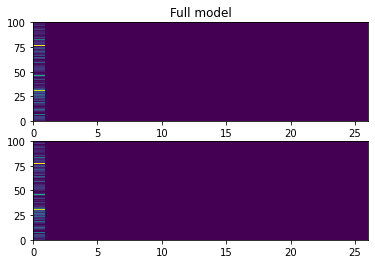

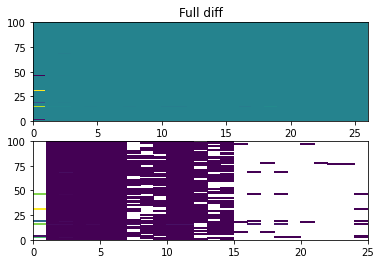

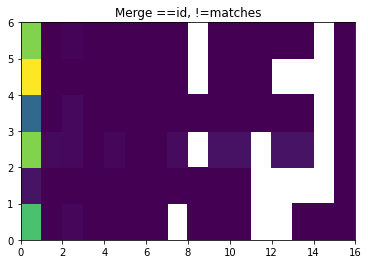

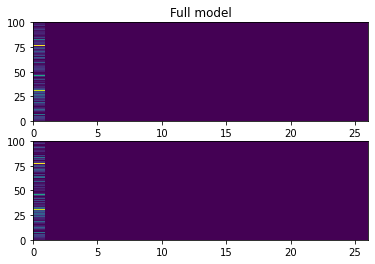

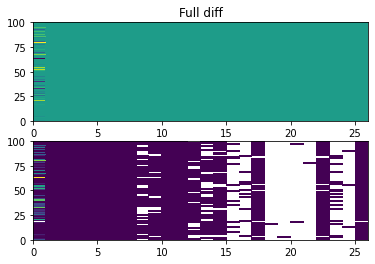

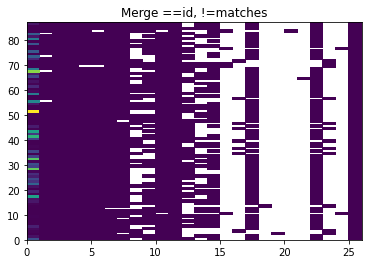

In [4]:
modelDF = getModelDf('../../datasets/model-clean.csv')
print('modelDF', modelDF.shape)
# minasFiModDF = getModelDf('../../out/minas-og/2020-07-22T01-19-11.984/model/653457_final.csv')
mfogModelDF = getModelDf('../../out/model.csv')
print('mfogModelDF', mfogModelDF.shape)

d = compareModelDf(modelDF, mfogModelDF)
print('model diff min', d.min().min())
print('model diff meanDistance', d['meanDistance'].abs().sum())

newIni = getModelDf('../../out/minas-og/2020-07-22T21-46-01.167/model/0_initial.csv')
newFin = getModelDf('../../out/minas-og/2020-07-22T21-46-01.167/model/653457_final.csv')
compareModelDf(modelDF, newIni)
# compareModelDf(newIni, newFin)
# compareModelDf(mfogModelDF, newIni)

In [5]:
# %history -g -f ../../ref/jupyter_hist.py

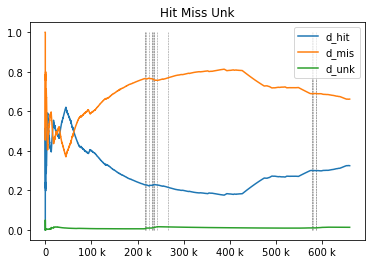

In [23]:
df = merge(examplesDf, mfogDF)
cf, classes, labels, offf, assignment = confusionMatrix(df)
# 
addHitMissUnkRate(df, assignment)
# 
labelSet = set()
xcoords = []
prevLen = len(offf)
for i, l in zip(df.index, df['label']):
    labelSet.add(l)
    if len(labelSet) > prevLen:
        prevLen = len(labelSet)
        xcoords += [i]
ax = df[['d_hit', 'd_mis', 'd_unk' ]].plot()
ax.set_title('Hit Miss Unk')
ax.vlines(x=xcoords, ymin=0, ymax=1, colors='gray', ls='--', lw=0.5, label='vline_multiple')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.EngFormatter())
# for xc in xcoords:
#     ax0.axvline(x=xc, color="gray", linestyle="--")
# .plot()
# df['hit']
# df
ax